{'input_parameters': {'planet_radius': np.float64(1.300241765), 'star_temperature': np.float64(3036.0), 'star_radius': np.float64(0.19), 'sma': np.float64(930498755.8), 'star_logg': np.float64(5.06), 'a/Rs': np.float64(7.039473728089088), 'Rp/Rs': np.float64(0.06273932352380034), 'albedo': 0.0, 'hrf': 0.6666666666666666, 'pos': 0.0, 'inclination': np.float64(88.5), 'mid_time': 2460000, 'eccentricity': 0.0, 'periastron': 0.0, 'period': np.float64(0.46292964), 'dayside_temperature': 1033, 'equilibrium_temperature': 809, 'nightside_temperature': 50, 'phase_curve_offset': 0.0}, 'data': {np.float64(0.7): {'model': {'time': array([2460000.1984676 , 2460000.19858334, 2460000.19869908, ...,
       2460000.72705482, 2460000.72717056, 2460000.7272863 ],
      shape=(4570,)), 'phase': array([2.69373266, 2.69530357, 2.69687448, ..., 9.86806583, 9.86963674,
       9.87120764], shape=(4570,)), 'pc': array([1.00000001, 1.00000001, 1.00000001, ..., 1.00000001, 1.00000001,
       1.00000001], shape=(45

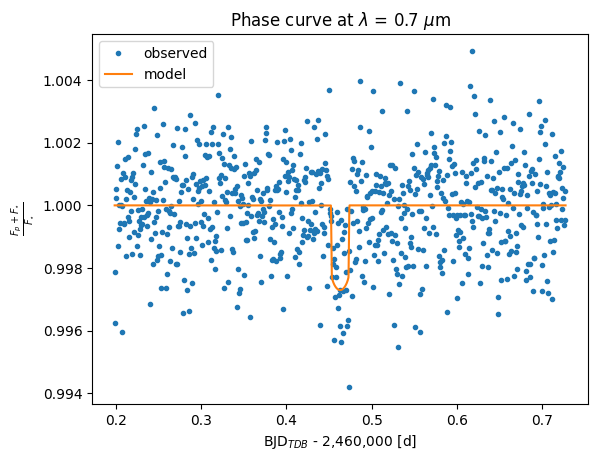

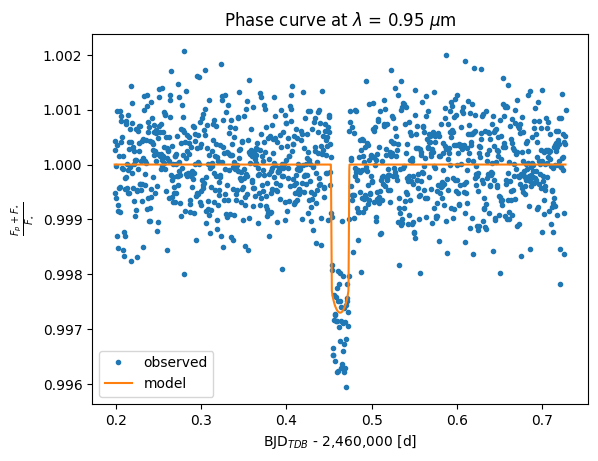

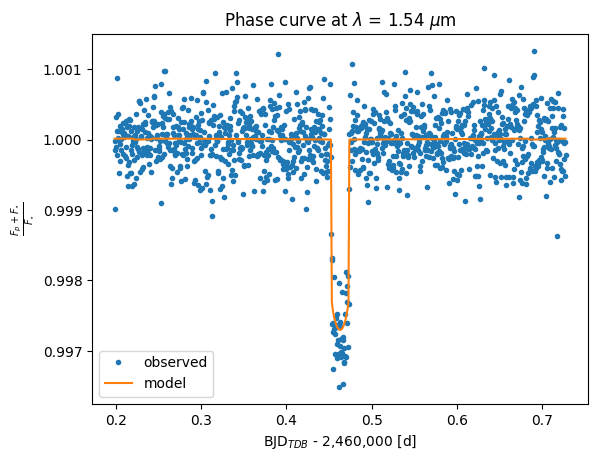

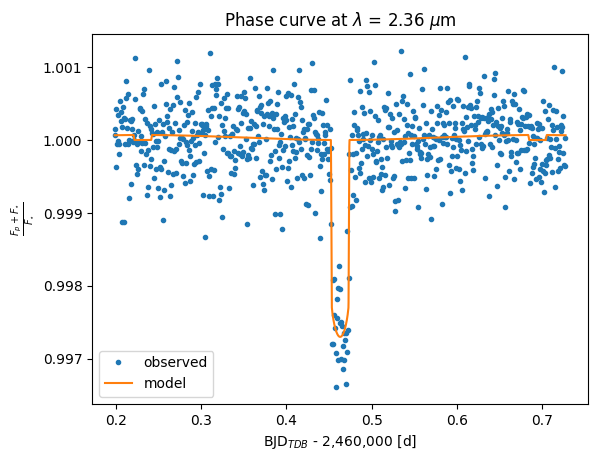

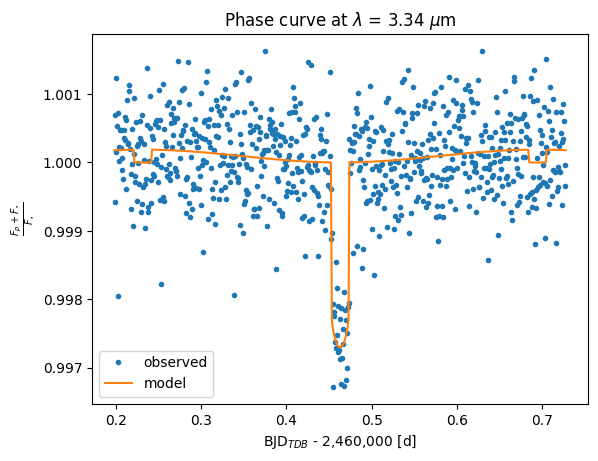

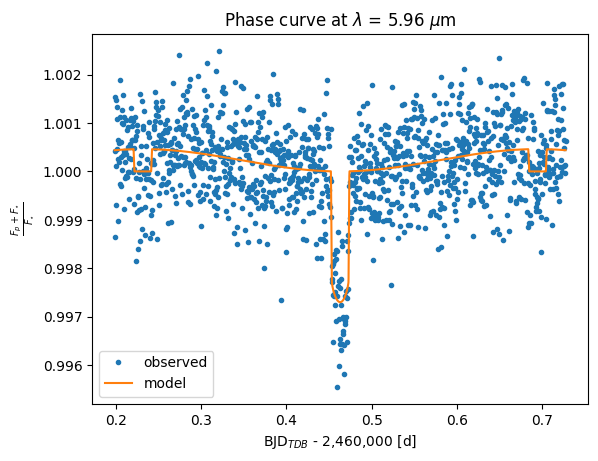

"\n    plt.figure()\n    plt.plot(observed_phase, observed_pc, label='observed')\n    plt.plot(model_phase, model_pc, label='model')\n    plt.title(rf'Phase curve at $\\lambda$ = {lamb} $\\mu$m')\n    plt.legend()\n    plt.xlabel('phase')\n    plt.ylabel(r'$\x0crac{F_p + F_{\\star}}{F_{\\star}}$')\n    plt.show()"

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
#%matplotlib notebook

df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")

print(df) 
print(type(df))
print(len(df))
print(df.keys())
print(df['input_parameters'])
print(df['data'].keys())

wvl = df['data'].keys()

print(df['data'][0.7].keys())

print(df['data'][0.7]['model']['time'] - 2460000)

for lamb in wvl:
    model_time = df['data'][lamb]['model']['time'] - 2460000
    model_phase = df['data'][lamb]['model']['phase']
    model_pc = df['data'][lamb]['model']['pc']
    observed_time = df['data'][lamb]['observed']['time'] - 2460000
    observed_phase = df['data'][lamb]['observed']['phase']
    observed_pc = df['data'][lamb]['observed']['pc']

    plt.figure()
    plt.plot(observed_time, observed_pc, '.', label='observed')
    plt.plot(model_time, model_pc, label='model')
    plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
    plt.legend()
    plt.xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
    plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
    plt.show()
"""
    plt.figure()
    plt.plot(observed_phase, observed_pc, label='observed')
    plt.plot(model_phase, model_pc, label='model')
    plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
    plt.legend()
    plt.xlabel('phase')
    plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
    plt.show()"""

[1. 1. 1. ... 1. 1. 1.]


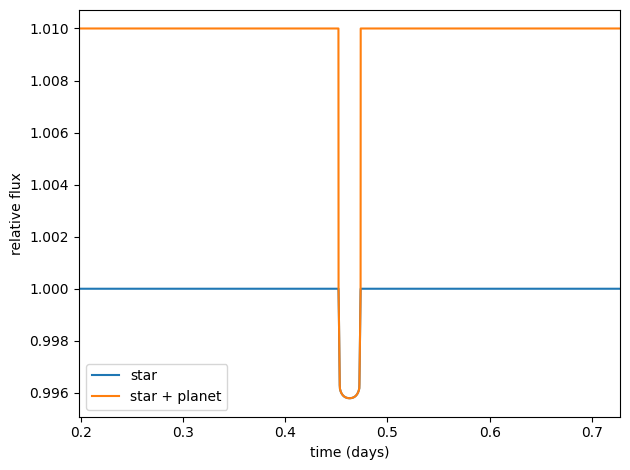

In [8]:
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve
import jax.numpy as jnp
from Solar_System_constants import *
from Phase_curve_v1 import *
from Phase_curve_TTV import *

"""
Lengths are in solar radii 
Masses are in solar masses
Times are in days.
Angles are in radians.
Data for LHS3844b taken from Kokori et al 2023, otherwise Vanderspek et al 2019
"""
transit_duration_days = 0.5212/24
period=0.46292964
time_transit=2458828.93037
impact_param=0.186
R_star = 0.1886240*R_Sun

orbit = TransitOrbit(
    period=period, duration=transit_duration_days, time_transit=0, impact_param=impact_param, radius_ratio=0.0635
)

# Compute a limb-darkened light curve for this orbit
time = df['data'][lamb]['model']['time'] - 2460000
uu = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, uu)(time)

# -----------------------------
# Planet phase curve (Lambertian)
# -----------------------------
# Planet position in 3D (units: stellar radii)
x, y, z = orbit.relative_position(time)

# Phase angle alpha: angle between star->planet and planet->observer
# Observer at +z, so cos(alpha) = -z / distance
r = jnp.sqrt(x**2 + y**2 + z**2)
cos_alpha = -z / r
alpha = jnp.arccos(jnp.clip(cos_alpha, -1, 1))

# Lambertian phase function
def lambert_phase(alpha):
    return (jnp.sin(alpha) + (jnp.pi - alpha) * jnp.cos(alpha)) / jnp.pi

# Max planet flux (full phase, alpha=0)
F0 = 0.01
planet_flux = F0#* lambert_phase(alpha)

# -----------------------------
# Secondary eclipse: mask planet flux
# -----------------------------
behind_star = (z > 0) & (x**2 + y**2 < R_star**2)
visibility = jnp.where(behind_star, 0.0, 1.0)
print(visibility)

lc_planet = planet_flux * visibility

# -----------------------------
# Total light curve
# -----------------------------
lc_total = light_curve + lc_planet

# Plot the light curve
plt.plot(time, light_curve+1, label='star')
plt.plot(time, lc_total+1, label='star + planet')
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
plt.legend()
plt.tight_layout()


[1.0000001 1.0000001 1.0000001 ... 1.0000001 1.0000001 1.0000001]


/tmp/ipykernel_67044/1236585680.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


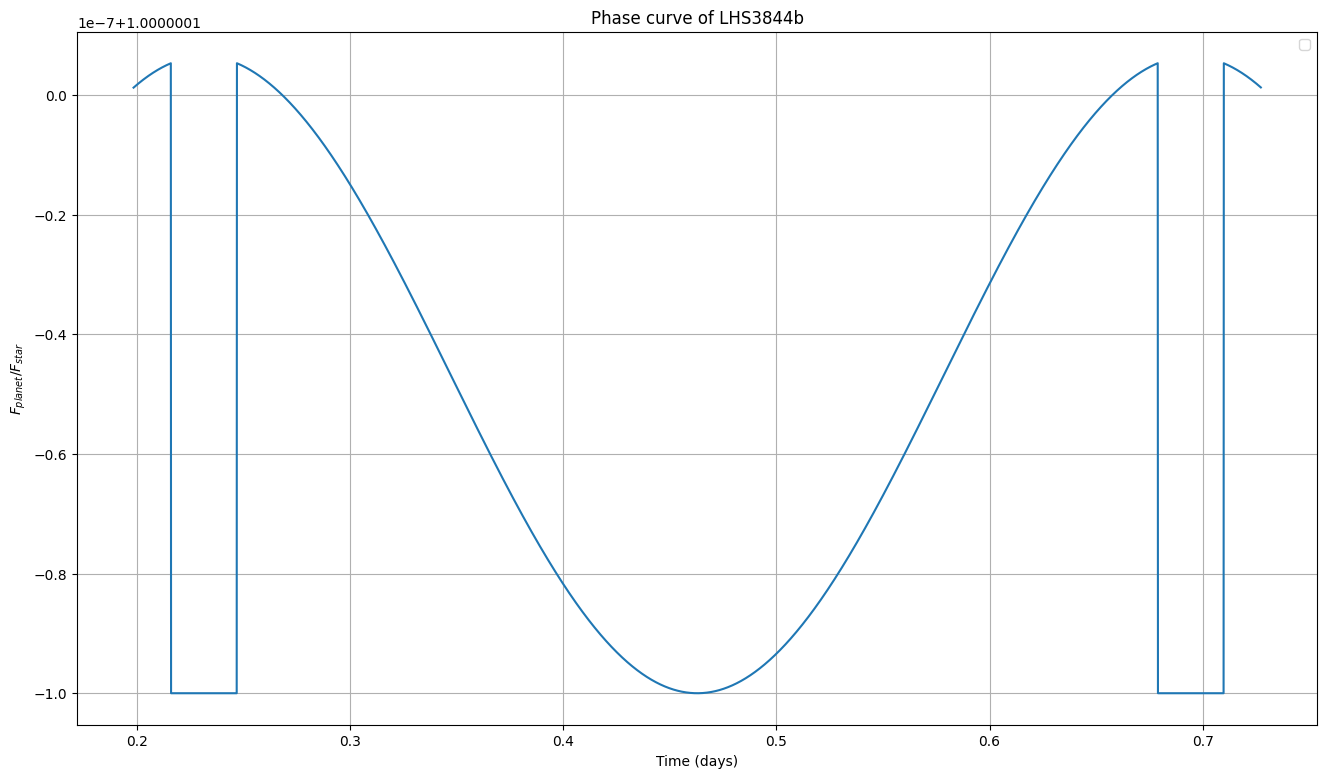

In [3]:
"""t_start = -0.2
t_end = 0.7 # simulation duration in days
nb_points = 10000 # number of points in the time array

t = np.linspace(t_start,t_end,nb_points) # time array in days"""

model_time = df['data'][lamb]['model']['time'] - 2460000
t_start = model_time[0]
t_end = model_time[len(model_time)-1]
nb_points = len(model_time)

t = model_time

# For LHS3844 b

e = 0.0
P = 0.46292964#*24*3600
omega = 0.0 # bcs e = 0
i = 88.5*np.pi/180
a = 0.00622*149597870700 # a in m
R_star = 0.1886240*R_Sun
R = 1.303*R_Earth 
L_star = (10**(-2.5833))*L_Sun


nu = compute_true_anomaly(0,e,P,t)
alpha = phase_angle(omega,nu,i)
#phase = phase_function(alpha)
# t0_b = omega_b/(2*np.pi)*P_b
# phase_b = phase_planet(t,P_b,t0_b)
phase = phase_TTV(P, t_start, t_end, [P], nb_points)[0]
b = eclipse_impact_parameter(a,i,e,R_star,omega)
eclipsee = eclipse(P,a,R_star,R,i,np.arccos(phase)/(2*np.pi),e,omega,b)

r = star_planet_separation(a,e,nu)

flux_starr = flux_star(L_star,r)
flux = flux_planet(flux_starr)
L = luminosity_planet_dayside(flux,R)

phase_curvee = phase_curve(L_star,L,R_star,R,phase,eclipsee)
print(phase_curvee)
# np.savetxt("Phase_curve_v1_output/phase_curve_b.txt",np.concatenate((t.reshape(nb_points,1),phase_curve_b.reshape(nb_points,1)),axis=1))

# Total signal

#phase_curve_total = phase_curve_b + phase_curve_c + phase_curve_d + phase_curve_e + phase_curve_f + phase_curve_g + phase_curve_h
# np.savetxt("Phase_curve_v1_output/phase_curve_total.txt",np.concatenate((t.reshape(nb_points,1),phase_curve_total.reshape(nb_points,1)),axis=1))



# Plot

# plt.figure()
# plt.plot(t,phase_b,label="b")
# plt.plot(t,phase_c,label="c")
# plt.xlabel("Time (days)")
# plt.ylabel("Phase")
# plt.title("Phase of planets of TRAPPIST-1")
# plt.legend()
# plt.grid()
# plt.show()

plt.figure(figsize=(16,9))
plt.plot(model_time,phase_curvee)
plt.xlabel("Time (days)")
plt.ylabel("$F_{planet}/F_{star}$ ")
plt.title("Phase curve of LHS3844b")
plt.legend()
plt.grid()
#plt.savefig("Phase_curve_v1_plots/Phase_curves_TRAPPIST1_bolometric.png", bbox_inches='tight')
plt.show()


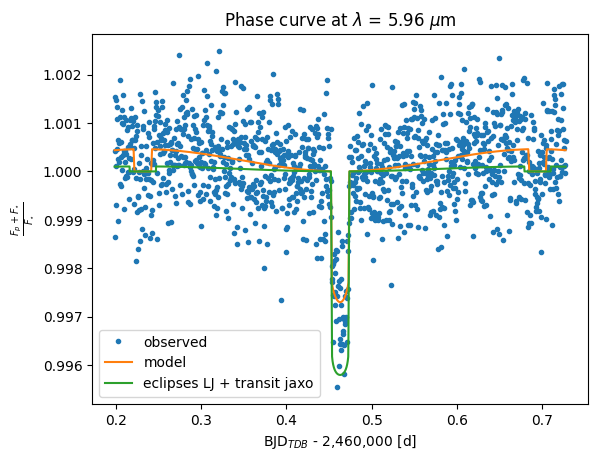

In [4]:
# MODEL BILLY + MODEL LOUIS-JULIEN

from Orbital_motion import compute_true_anomaly
from Transits import eclipse, eclipse_impact_parameter
from Solar_System_constants import *
from Phase_curve_v1 import *
from Phase_curve_TTV import *

lamb = 5.96
model_time = df['data'][lamb]['model']['time'] - 2460000
model_pc = df['data'][lamb]['model']['pc']
observed_time = df['data'][lamb]['observed']['time'] - 2460000
observed_pc = df['data'][lamb]['observed']['pc']

e = 0.0
P = 0.46292964#*24*3600
omega = 0.0 # bcs e = 0
i = 88.5*np.pi/180
a = 0.00622*149597870700 # a in m
R_star = 0.1886240*R_Sun
R = 1.303*R_Earth 
#L_star = (10**(-2.5833))*L_Sun

lambda_1 = 1.95
lambda_2 = 7.8
T_star = 3036
L_star = luminosity_bb(T_star, lambda_1, lambda_2)
T_planet = 805
L = luminosity_bb(T_planet, lambda_1, lambda_2)

t0 = model_time[0]
t_end = model_time[len(model_time)-1]
nb_points = len(model_time)

phase = phase_TTV(P, t0, t_end, [P], nb_points)[0]
nu = compute_true_anomaly(0,e,P,model_time)
alpha = phase_angle(omega,nu,i)
#phase = phase_function(alpha)
# t0_b = omega_b/(2*np.pi)*P_b
# phase_b = phase_planet(t,P_b,t0_b)
b = eclipse_impact_parameter(a,i,e,R_star,omega)
eclipsee = eclipse(P,a,R_star,R,i,np.arccos(phase)/(2*np.pi),e,omega,b)

r = star_planet_separation(a,e,nu)

"""flux_starr = flux_star(L_star,r)
flux = flux_planet(flux_starr)
L = luminosity_planet_dayside(flux,R)"""

phase_curvee = phase_curve(L_star,L,R_star,R,phase,eclipsee) 
#phase_curvee = phase_curvee / np.mean(phase_curvee)
phase_curvee = np.array(phase_curvee, dtype='float64')

light_curve = limb_dark_light_curve(orbit, uu)(model_time) 

fig, ax = plt.subplots()
plt.plot(observed_time, observed_pc, '.',label='observed')
plt.plot(model_time, model_pc, label='model')
#ax.plot(model_time,phase_curvee, label='eclipses LJ')
ax.plot(model_time,phase_curvee + light_curve, label='eclipses LJ + transit jaxo')
#plt.plot(model_time,light_curve+1, label='transit jaxo')
ax.set_title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
ax.legend()
ax.set_xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
ax.set_ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
#ax.ticklabel_format(style='plain', axis='y')  # disable scientific offset
#ax.yaxis.offsetText.set_visible(False)        # hide the "1e-7 + ..." text
plt.show()

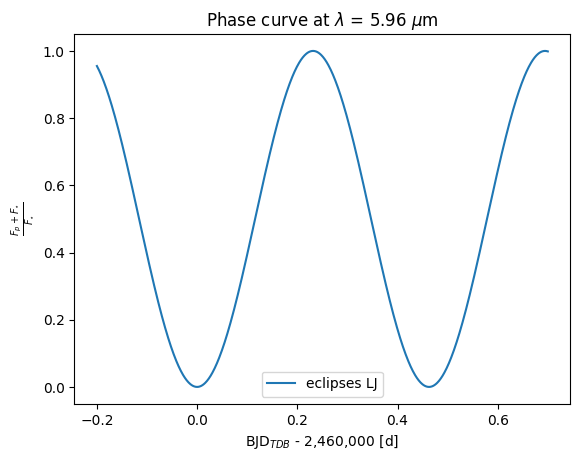

In [5]:
t0 = -0.2
t_end = 0.7
nb_points = 1000
P = 0.46292964
t = np.linspace(t0, t_end, nb_points)
phase_curvee = phase_TTV(P, t0, t_end, [0], nb_points)[0]

plt.figure()
plt.plot(t,phase_curvee, label='eclipses LJ')
plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
plt.legend()
plt.xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()

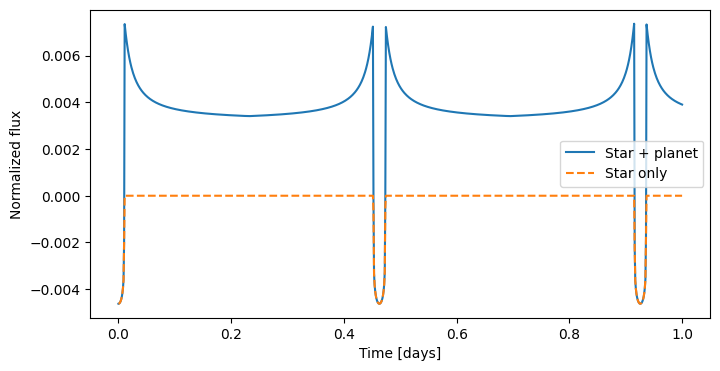

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

# -----------------------------
# Orbital + stellar parameters
# -----------------------------
period = 1.0          # days
r_star = 1.0          # stellar radius (normalized)
r_planet = 0.1        # planet radius (in stellar radii)
a = 5.0               # semi-major axis in stellar radii
incl = 90.0           # degrees (edge-on)
t0 = 0.0              # reference transit midtime

# Quadratic limb darkening
u = jnp.array([0.3, 0.2])

# -----------------------------
# Orbit
# -----------------------------
transit_duration_days = 0.5212/24
period=0.46292964
time_transit=2458828.93037
impact_param=0.186

orbit = TransitOrbit(
    period=period, duration=transit_duration_days, time_transit=0, impact_param=impact_param, radius_ratio=0.0635
)

# Time array
t = jnp.linspace(0, 1, 1000)  # in days

# -----------------------------
# Stellar light curve
# -----------------------------
lc_star = limb_dark_light_curve(orbit, u)(t)

# -----------------------------
# Planet phase curve (Lambertian)
# -----------------------------
# Planet position in 3D (units: stellar radii)
x, y, z = orbit.relative_position(t)

# Phase angle alpha: angle between star->planet and planet->observer
# Observer at +z, so cos(alpha) = -z / distance
r = jnp.sqrt(x**2 + y**2 + z**2)
cos_alpha = -z / r
alpha = jnp.arccos(jnp.clip(cos_alpha, -1, 1))

# Lambertian phase function
def lambert_phase(alpha):
    return (jnp.sin(alpha) + (jnp.pi - alpha) * jnp.cos(alpha)) / jnp.pi

# Max planet flux (full phase, alpha=0)
F0 = 0.01
planet_flux = F0 * lambert_phase(alpha)

# -----------------------------
# Secondary eclipse: mask planet flux
# -----------------------------
behind_star = (z > 0) & (x**2 + y**2 < r_star**2)
visibility = jnp.where(behind_star, 0.0, 1.0)

lc_planet = planet_flux * visibility

# -----------------------------
# Total light curve
# -----------------------------
lc_total = lc_star + lc_planet

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(t, lc_total, label="Star + planet")
plt.plot(t, lc_star, "--", label="Star only")
#plt.axhline(1.0, color="k", lw=0.5)
plt.xlabel("Time [days]")
plt.ylabel("Normalized flux")
plt.legend()
plt.show()
